<a href="https://colab.research.google.com/github/kurota0612/feedback-prize-2021/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##まずはEDA

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use("fivethirtyeight")
from matplotlib.ticker import FuncFormatter
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")
import spacy
from sklearn.feature_extraction.text import CountVectorizer
import os

In [2]:
train = pd.read_csv("/content/drive/MyDrive/Kaggle/feedback-prize-2021/train.csv")
train[["discourse_id", "discourse_start", "discourse_end"]] = train[["discourse_id", "discourse_start", "discourse_end"]].astype(int)

sample_submission = pd.read_csv("/content/drive/MyDrive/Kaggle/feedback-prize-2021/sample_submission.csv")

# globモジュール：Unixシェルのルールに従って指定されたパターンに一致するすべてのパスを見つける
train_txt = glob("/content/drive/MyDrive/Kaggle/feedback-prize-2021/train/*.txt")
test_txt = glob("/content/drive/MyDrive/Kaggle/feedback-prize-2021/test/*.txt")

### このコンペの概要

基本的には12〜18歳くらいの子どもが書いた作文の中から7種の「discourse type」に分類される言葉の並びを探す、というもの

1.   Lead - 統計、引用、説明など、読者の注意を引き、論文に向かわせる工夫で始まる導入部分
2. Position - 主な質問に対する意見または結論
3. Claim - その立場を支持する主張
4. Counterclaim - 他のclaimに反論する、または立場に対して反対理由を与える主張。
5. Rebuttal - counterclaimに反論する主張
6. Evidence - claim、coutertclaim、またはrebuttalをサポートするアイデアや例。
7. Conclusion Statement - claimを再表現する結論となる文章



---

適当な1文を見てみる

[catコマンド](https://eng-entrance.com/linux_command_cat)




In [3]:
!cat /content/drive/MyDrive/Kaggle/feedback-prize-2021/train/423A1CA112E2.txt

Phones

Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it.

When people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation.

Driving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Problems. That's why there's a thing that's called no texting while driving. That's a really important thing to remember. S

train datasetsには、上のエッセイ（ある学生が書いた1文）から抽出されたアノテーションが載っている

In [7]:
train.query("id == '423A1CA112E2'")

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1622627660524,8,229,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1622627653021,230,312,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1622627671020,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1622627696365,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1622627759780,759,886,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...
5,423A1CA112E2,1622627780655,887,1150,That's why there's a thing that's called no te...,Evidence,Evidence 3,163 164 165 166 167 168 169 170 171 172 173 17...
6,423A1CA112E2,1622627811787,1151,1533,Sometimes on the news there is either an accid...,Evidence,Evidence 4,211 212 213 214 215 216 217 218 219 220 221 22...
7,423A1CA112E2,1622627585180,1534,1602,Phones are fine to use and it's also the best ...,Claim,Claim 2,282 283 284 285 286 287 288 289 290 291 292 29...
8,423A1CA112E2,1622627895668,1603,1890,If you go through a problem and you can't find...,Evidence,Evidence 5,297 298 299 300 301 302 303 304 305 306 307 30...
9,423A1CA112E2,1622627628524,1891,2027,The news always updated when people do somethi...,Concluding Statement,Concluding Statement 1,355 356 357 358 359 360 361 362 363 364 365 36...


train datasetsには以下のカラムがある



*   id - ID code for essay response
*   discourse_id - ID code for discourse element
*   discourse_start - character position where discourse element begins in the essay response
*   discourse_end - character position where discourse element ends in the essay response
*   discourse_text - text of discourse element
*   discourse_type - classification of discourse element
*   discourse_type_num - enumerated class label of discourse element
*   predictionstring - the word indices of the training sample, as required for predictions

ここでのGround Truthは、discourse typeとprediction stringの組み合わせである。predictionstringはエッセイの単語のインデックスに対応し、この単語の並びに対して予測されるdiscourse typeは正しいはずである。もし、正しいdiscourse typeが予測されたとしても、Ground Truthで指定されたものより長い、あるいは短い単語列であれば、部分一致となる可能性がある。

このように、必ずしもエッセイのすべてのテキストがdiscourse typeに含まれるとは限らない。この場合、タイトルはどのdiscourseにも属さない。



**discourse_textとpredictionstringの長さ**

まず、discourse_textとpredictionstringが常に同じ単語数であるか（あるべき姿）を確認したいと思います。

In [10]:
# カラムの追加
train["discourse_len"] = train["discourse_text"].apply(lambda x: len(x.split()))
train["pred_len"] = train["predictionstring"].apply(lambda x: len(x.split()))

cols_to_display = ['discourse_id', 'discourse_text', 'discourse_type','predictionstring', 'discourse_len', 'pred_len']
train[cols_to_display].head()

,discourse_id,discourse_text,discourse_type,predictionstring,discourse_len,pred_len
0,1622627660524,Modern humans today are always on their phone....,Lead,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,44,44
1,1622627653021,They are some really bad consequences when stu...,Position,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,15,15
2,1622627671020,Some certain areas in the United States ban ph...,Evidence,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,16,16
3,1622627696365,"When people have phones, they know about certa...",Evidence,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,63,63
4,1622627759780,Driving is one of the way how to get around. P...,Claim,139 140 141 142 143 144 145 146 147 148 149 15...,24,24


一見合ってそうだが、実は1単語分間違ってるやつが468個ある

In [11]:
print(f"The total number of discourses is {len(train)}")
train.query("discourse_len != pred_len")[cols_to_display]

The total number of discourses is 144293


,discourse_id,discourse_text,discourse_type,predictionstring,discourse_len,pred_len
107,1622473475289,if we would just make stricker laws for phone ...,Concluding Statement,303 304 305 306 307 308 309 310 311 312 313 31...,19,18
1025,1622564912260,for navigation to wherever they are going,Claim,105 106 107 108 109 110 111 112,7,8
1525,1622992466917,People should not be able to use cell phones w...,Position,22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 3...,47,48
1526,1622992280991,"First, cell phones are a benefit and allows ev...",Claim,69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 8...,21,22
1527,1622992426147,"Kids, teenagers, adults, even grandparents hav...",Evidence,90 91 92 93 94 95 96 97 98 99 100 101 102 103 ...,78,79
...,...,...,...,...,...,...
142607,1617826841342,seeking people's opinions on making a choice i...,Concluding Statement,563 564 565 566 567 568 569 570 571 572 573 57...,51,50
143191,1617887956153,i feel like for the bst advice ask more then o...,Evidence,185 186 187 188 189 190 191 192 193 194 195 19...,83,82
143227,1617652582742,", asking for advice from multiple people will ...",Concluding Statement,467 468 469 470 471 472 473 474 475 476 477 47...,84,83
143311,1618286838241,Seeking multiple opinions can help make a bett...,Claim,159 160 161 162 163 164 165 166 167 168 169 17...,15,16


1個目を見てみる

それぞれ本当に19個と18個になっている。ひとまず注意しておく

In [18]:
print(train.query("discourse_id == 1622473475289")["discourse_text"].values[0])
print(train.query("discourse_id == 1622473475289")["discourse_text"].values[0].split())
print(len(train.query("discourse_id == 1622473475289")["discourse_text"].values[0].split()))

if we would just make stricker laws for phone an driving the people would stop because of the consequences.      
['if', 'we', 'would', 'just', 'make', 'stricker', 'laws', 'for', 'phone', 'an', 'driving', 'the', 'people', 'would', 'stop', 'because', 'of', 'the', 'consequences.']
19


In [19]:
print(train.query("discourse_id == 1622473475289")["predictionstring"].values[0])
print(train.query("discourse_id == 1622473475289")["predictionstring"].values[0].split())
print(len(train.query("discourse_id == 1622473475289")["predictionstring"].values[0].split()))

303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320
['303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320']
18


**discourse_typeごとの「文の長さ」と「出現頻度」の比較**

discourseの長さとクラス（discourse_type）には相関があるのでしょうか？はい、あります。Evidenceは平均して最も長いディスコースタイプです。出現頻度を見ると、CounterclaimとRebuttalは比較的まれであることがわかります

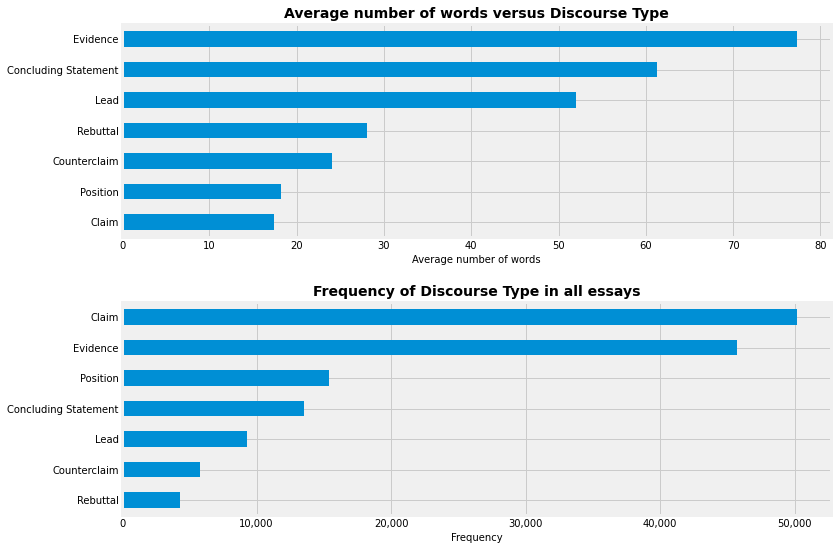

In [21]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(211)
ax1 = train.groupby("discourse_type")["discourse_len"].mean().sort_values().plot(kind="barh")
ax1.set_title("Average number of words versus Discourse Type", fontsize=14, fontweight="bold")
ax1.set_xlabel("Average number of words", fontsize=10)
ax1.set_ylabel("")

ax2 = fig.add_subplot(212)
ax2 = train.groupby('discourse_type')['discourse_type'].count().sort_values().plot(kind="barh")
ax2.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
ax2.set_title("Frequency of Discourse Type in all essays", fontsize=14, fontweight = 'bold')
ax2.set_xlabel("Frequency", fontsize = 10)
ax2.set_ylabel("")

plt.tight_layout(pad=2)
plt.show()

discourse_type_numというフィールドがあります。Evidence1、Position1、Claim1 は、小論文の中でほとんど常に存在することがわかります。また、ほとんどの学生が少なくとも1つのConcluding Statementを持っています。驚くべきは、約40%の小論文でLeadが欠落していることです（Lead 1はほぼ60%の小論文に見られます）。

このグラフでは、少なくとも3％の作文に含まれるdiscourse_type_numのみをプロットしています。

AttributeError: ignored

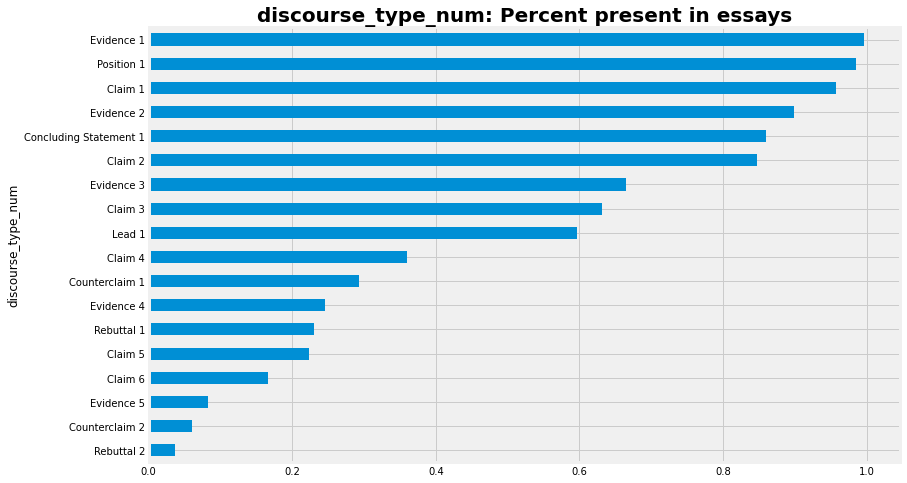

In [24]:
fig = plt.figure(figsize=(12,8))
av_per_essay = train['discourse_type_num'].value_counts(ascending = True).rename_axis('discourse_type_num').reset_index(name='count')
av_per_essay['perc'] = round((av_per_essay['count'] / train.id.nunique()),3)
av_per_essay = av_per_essay.set_index('discourse_type_num')
ax = av_per_essay.query('perc > 0.03')['perc'].plot(kind="barh")
ax.set_title("discourse_type_num: Percent present in essays", fontsize=20, fontweight = 'bold')
ax.bar_label(ax.containers[0], label_type="edge")
ax.set_xlabel("Percent")
ax.set_ylabel("")
plt.show()